# Fine Tune Transformers from HuggingFace MiniLM

**Note: This notebook is run in Paperspace platform**

In [1]:
%pip install transformers
%pip install torch
%pip install imblearn
%pip install wandb --upgrade


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback, set_seed

# Progress bar
from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import tqdm
tqdm_notebook.pandas()

/tmp/ipykernel_6229/491656687.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


## Import Clean Text Data

In [3]:
###############################################################
# Note: Change the name of data set used for feature creation
###############################################################
data_set='bully_data_clean_with_stopword'
    
    
###################
# Import Data Set #
###################
bully_data_cleaned = pd.read_csv('bully_data_clean_with_stopword.csv', encoding='utf8')                                            
bully_data_cleaned = bully_data_cleaned[~bully_data_cleaned['text_check'].isna()]
bully_data_cleaned = bully_data_cleaned[bully_data_cleaned['text_check'] != ""]
#bully_data_cleaned = bully_data_cleaned[bully_data_cleaned['role']!='None']
bully_data_cleaned = bully_data_cleaned[['label','text_check']]
bully_data_cleaned['label'] = bully_data_cleaned['label'].progress_apply(lambda x: 1 if x =="Cyberbullying" else 0)
bully_data_cleaned.rename(columns = {'text_check':'text'}, inplace = True)
bully_data_cleaned = bully_data_cleaned.reset_index(drop=True)

  0%|          | 0/120932 [00:00<?, ?it/s]

In [4]:
bully_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120932 entries, 0 to 120931
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   120932 non-null  int64 
 1   text    120932 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [72]:
bully_data_cleaned['label'].value_counts()

0    115556
1      5376
Name: label, dtype: int64

## Define pretrained tokenizer and model

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
set_seed(1127)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Preprocess data and Fine Tune Transformers

In [6]:
# Data: Text Input and Label 
X = list(bully_data_cleaned["text"])
y = list(bully_data_cleaned["label"])


# Create torch dataset 
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


# Define Trainer parameters 
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall_cb = recall_score(y_true=labels, y_pred=pred, average='binary', pos_label=1)
    precision_cb = precision_score(y_true=labels, y_pred=pred, average='binary', pos_label=1)
    f1_cb = f1_score(y_true=labels, y_pred=pred, average='binary', pos_label=1)
    
    recall_ncb = recall_score(y_true=labels, y_pred=pred, average='binary', pos_label=0)
    precision_ncb = precision_score(y_true=labels, y_pred=pred, average='binary', pos_label=0)
    f1_ncb = f1_score(y_true=labels, y_pred=pred, average='binary', pos_label=0)
    
    recall_overall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision_overall = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1_overall = f1_score(y_true=labels, y_pred=pred, average='macro')


    return {"accuracy": accuracy, 
            "precision_cb": precision_cb, "recall_cb": recall_cb, "f1_cb": f1_cb,
            "precision_ncb": precision_ncb, "recall_ncb": recall_ncb, "f1_ncb": f1_ncb,
            "precision_overall": precision_overall, "recall_overall": recall_overall, "f1_overall": f1_overall}


# Plot Confusion Matrix 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CONFUSION MATRIX IN PERCENTAGE
    cf_pct = cf.astype('float')/cf.sum(axis=1)[:, np.newaxis]
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf_pct.flatten()]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf_pct,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


# Run cross-validation 
def run_cross_validation(model_name='MiniLM',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=4,
                         checkpoint=False):
    
    kfold = StratifiedShuffleSplit(n_splits=splits, test_size=0.1, random_state=1127)
    n_fold = 1

    print("Developing Model with Cross validation for: " + model_name)
    for train, test in tqdm(kfold.split(X, y)):

        print("Running for Fold: ",n_fold)
        train_index = list(train)
        test_index = list(test)

        X_train = [X[i] for i in train_index]
        y_train = [y[i] for i in train_index]
        X_val = [X[i] for i in test_index]
        y_val = [y[i] for i in test_index]

        # Tokenize
        X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
        X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

        # Create torch dataset
        train_dataset = Dataset(X_train_tokenized, y_train)
        val_dataset = Dataset(X_val_tokenized, y_val)

        # Define Trainer
        args = TrainingArguments(
            output_dir="content/drive/MyDrive_binary/output_" + model_name + "/fold"+str(n_fold),
            evaluation_strategy="epoch",
            save_strategy="epoch",
            num_train_epochs=epoch,
            seed=1127,
            load_best_model_at_end=True,
        )

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        )

        if n_fold <= 4:
            checkpoint_temp = True
        else:
            checkpoint_temp = False

        trainer.train(resume_from_checkpoint=checkpoint)  # Add gradient_clip_val
        print("Complete for fold", n_fold)
        n_fold = n_fold + 1



# Run Hold Out Test 

# Train and Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1127)

# Train and Validate Set
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=1127)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_test)

def run_hold_out_split(model_name='MiniLM',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=False):
  
    print("Developing Model with Hold Out Splits for: " + model_name)
    # Fine Tune Transformer
    # Define Trainer
    args = TrainingArguments(
      output_dir="content/drive/MyDrive_binary/output_" + model_name + "/holdout",
      evaluation_strategy="epoch",
      save_strategy="epoch",
      #eval_steps=500,
      #per_device_train_batch_size=1,
      #per_device_eval_batch_size=1,
      num_train_epochs=epoch, #1 was okay
      seed=1127,
      load_best_model_at_end=True,
    )

    trainer = Trainer(
    # model_init=model_init,
    args=args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    )

    trainer.train(resume_from_checkpoint=checkpoint)
    print("Complete for hold-out validate set")


In [7]:
# Predict (Hold Out Test) 

from sklearn.metrics import confusion_matrix
def compute_metrics_holdout(model_name='MiniLM',
                            model_path='content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-3820', 
                            average_method='binary',
                            X_test=X_test):
  
    X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

    # Create torch dataset
    test_dataset = Dataset(X_test_tokenized)

    # Load trained model
    model_pred = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

    # Define test trainer
    test_trainer = Trainer(model_pred)

    # Make prediction
    raw_pred, _, _ = test_trainer.predict(test_dataset)

    # Preprocess raw predictions
    y_pred = np.argmax(raw_pred, axis=1)

    # Compute metrics
    precision_cb = precision_score(y_test, y_pred, average=average_method, pos_label=1)
    recall_cb = recall_score(y_test, y_pred, average=average_method, pos_label=1)
    f1_cb = f1_score(y_test, y_pred, average=average_method, pos_label=1)

    precision_ncb = precision_score(y_test, y_pred, average=average_method, pos_label=0)
    recall_ncb = recall_score(y_test, y_pred, average=average_method, pos_label=0)
    f1_ncb = f1_score(y_test, y_pred, average=average_method, pos_label=0)

    precision_overall = precision_score(y_test, y_pred, average='macro')
    recall_overall = recall_score(y_test, y_pred, average='macro')
    f1_overall = f1_score(y_test, y_pred, average='macro')

    # Print Results
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print()
    print("Label 1: Cyberbullying")
    print("Precision: ", precision_cb)
    print("Recall: ", recall_cb)
    print("F-measure: ", f1_cb)
    print()
    print("Label 0: Non-Cyberbullying")
    print("Precision: ", precision_ncb)
    print("Recall: ", recall_ncb)
    print("F-measure: ", f1_ncb)
    print()
    print("Macro Metrics")
    print("Precision: ", precision_overall)
    print("Recall: ", recall_overall)
    print("F-measure: ", f1_overall)
    print()

    # Confusion Matrix
    conf_mat = confusion_matrix(y_test,y_pred)
    categories = ['Non-Cyberbullying', 'Cyberbullying']
    labels = ['True Negative','',
            '','True Positive']

    make_confusion_matrix(conf_mat, 
                        group_names=labels,
                        categories=categories, 
                        figsize=(8,5), 
                        cbar=True, 
                        title='Fine Tuned ' + model_name + ' for Cyberbullying Detection', 
                        cmap='YlGnBu', 
                        sum_stats=False)



## Cross Validation (K = 5)

In [76]:
run_cross_validation(model_name='MiniLM',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=4,
                         checkpoint=False)

Developing Model with Cross validation for: MiniLM


0it [00:00, ?it/s]

Running for Fold:  1


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 108838
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 27212
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/usr/local/lib/python3.9/dist-packages/torch/n

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.095200,0.094568,0.965437,0.611111,0.613383,0.612245,0.981998,0.981828,0.981913,0.796554,0.797605,0.797079
2,0.088600,0.098155,0.965437,0.607527,0.630112,0.618613,0.982750,0.981049,0.981898,0.795138,0.805580,0.800256
3,0.068100,0.115298,0.967091,0.647059,0.572491,0.607495,0.980203,0.985462,0.982826,0.813631,0.778976,0.795160
4,0.052800,0.136595,0.965685,0.627329,0.563197,0.593536,0.979761,0.984424,0.982087,0.803545,0.773810,0.787811


***** Running Evaluation *****
  Num examples = 12094
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold1/checkpoint-6803
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold1/checkpoint-6803/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold1/checkpoint-6803/pytorch_model.bin
/usr/local/lib/python3.9/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 12094
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold1/checkpoint-13606
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold1/checkpoint-13606/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold1/checkpoint-13606/py

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 108838
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 27212
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/usr/local/lib/python3.9/dist-packages/torch/n

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.098800,0.084813,0.973871,0.748879,0.620818,0.678862,0.982486,0.990308,0.986382,0.865683,0.805563,0.832622
2,0.070000,0.095506,0.971639,0.703549,0.626394,0.662734,0.982695,0.987712,0.985197,0.843122,0.807053,0.823965
3,0.065900,0.111611,0.973127,0.738255,0.613383,0.670051,0.982141,0.989875,0.985993,0.860198,0.801629,0.828022
4,0.040100,0.123968,0.972383,0.717021,0.626394,0.668651,0.982708,0.988491,0.985591,0.849865,0.807442,0.827121


***** Running Evaluation *****
  Num examples = 12094
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold2/checkpoint-6803
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold2/checkpoint-6803/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold2/checkpoint-6803/pytorch_model.bin
/usr/local/lib/python3.9/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 12094
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold2/checkpoint-13606
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold2/checkpoint-13606/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold2/checkpoint-13606/py

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 108838
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 27212
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/usr/local/lib/python3.9/dist-packages/torch/n

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.079400,0.086898,0.973375,0.867347,0.473978,0.612981,0.976017,0.996625,0.986213,0.921682,0.735301,0.799597
2,0.066900,0.094763,0.973458,0.730361,0.639405,0.681863,0.983309,0.989010,0.986151,0.856835,0.814208,0.834007
3,0.042100,0.098754,0.975773,0.764579,0.657993,0.707293,0.984180,0.990568,0.987364,0.874380,0.824280,0.847328
4,0.033400,0.118398,0.975690,0.769912,0.646840,0.703030,0.983680,0.991000,0.987326,0.876796,0.818920,0.845178


***** Running Evaluation *****
  Num examples = 12094
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold3/checkpoint-6803
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold3/checkpoint-6803/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold3/checkpoint-6803/pytorch_model.bin
/usr/local/lib/python3.9/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 12094
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold3/checkpoint-13606
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold3/checkpoint-13606/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold3/checkpoint-13606/py

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 108838
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 27212
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/usr/local/lib/python3.9/dist-packages/torch/n

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.069800,0.060343,0.981809,0.816733,0.762082,0.788462,0.988958,0.992039,0.990496,0.902845,0.877060,0.889479
2,0.048800,0.079053,0.980238,0.884319,0.639405,0.742179,0.983426,0.996106,0.989725,0.933872,0.817756,0.865952
3,0.031800,0.082326,0.981065,0.832258,0.719331,0.771685,0.987015,0.993250,0.990123,0.909637,0.856291,0.880904
4,0.023400,0.091350,0.982057,0.842217,0.734201,0.784508,0.987699,0.993596,0.990639,0.914958,0.863899,0.887574


***** Running Evaluation *****
  Num examples = 12094
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold4/checkpoint-6803
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold4/checkpoint-6803/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold4/checkpoint-6803/pytorch_model.bin
/usr/local/lib/python3.9/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 12094
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold4/checkpoint-13606
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold4/checkpoint-13606/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold4/checkpoint-13606/py

Complete for fold 4
Running for Fold:  5


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 108838
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 27212
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/usr/local/lib/python3.9/dist-packages/torch/n

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.055500,0.047071,0.985117,0.862348,0.791822,0.825581,0.990345,0.994116,0.992227,0.926347,0.892969,0.908904
2,0.045600,0.059772,0.984372,0.864301,0.769517,0.814159,0.989324,0.994375,0.991843,0.926812,0.881946,0.903001
3,0.038800,0.064670,0.984951,0.838403,0.819703,0.828947,0.991615,0.992645,0.992129,0.915009,0.906174,0.910538
4,0.024000,0.069853,0.985861,0.881497,0.788104,0.832188,0.990183,0.995067,0.992619,0.935840,0.891586,0.912404


***** Running Evaluation *****
  Num examples = 12094
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold5/checkpoint-6803
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold5/checkpoint-6803/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold5/checkpoint-6803/pytorch_model.bin
/usr/local/lib/python3.9/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 12094
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/fold5/checkpoint-13606
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/fold5/checkpoint-13606/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/fold5/checkpoint-13606/py

Complete for fold 5


### [Continue] Cross Validation (K = 5)

In [77]:
run_cross_validation(model_name='MiniLM',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=4,
                         checkpoint=True)

Developing Model with Cross validation for: MiniLM


0it [00:00, ?it/s]

Running for Fold:  1


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_MiniLM/fold1/checkpoint-27212.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 108838
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 27212
  Continuing training from checkpoint, will skip to saved

0it [00:00, ?it/s]

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_MiniLM/fold1/checkpoint-6803 (score: 0.09456759691238403).


Epoch,Training Loss,Validation Loss


1it [00:14, 14.66s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_MiniLM/fold2/checkpoint-27212.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 108838
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 27212
  Continuing training from checkpoint, will skip to saved

0it [00:00, ?it/s]

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_MiniLM/fold2/checkpoint-6803 (score: 0.08481282740831375).


Epoch,Training Loss,Validation Loss


2it [00:30, 15.57s/it]

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_MiniLM/fold3/checkpoint-27212.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 108838
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 27212
  Continuing training from checkpoint, will skip to saved

0it [00:00, ?it/s]

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_MiniLM/fold3/checkpoint-6803 (score: 0.08689761906862259).


Epoch,Training Loss,Validation Loss


3it [00:42, 13.73s/it]

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_MiniLM/fold4/checkpoint-27212.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 108838
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 27212
  Continuing training from checkpoint, will skip to saved

0it [00:00, ?it/s]

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_MiniLM/fold4/checkpoint-6803 (score: 0.06034262478351593).


Epoch,Training Loss,Validation Loss


4it [00:57, 14.26s/it]

Complete for fold 4
Running for Fold:  5


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_MiniLM/fold5/checkpoint-27212.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 108838
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 27212
  Continuing training from checkpoint, will skip to saved

0it [00:00, ?it/s]

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_MiniLM/fold5/checkpoint-6803 (score: 0.04707089811563492).


Epoch,Training Loss,Validation Loss


5it [01:12, 14.57s/it]


Complete for fold 5


## Hold Out Split

In [8]:
#holdout
run_hold_out_split(model_name='MiniLM',
                       epoch=4,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=False)

Developing Model with Hold Out Splits for: MiniLM
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 108838
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 27212
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/usr/local/lib/python3.9/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.095200,0.094568,0.965437,0.611111,0.613383,0.612245,0.981998,0.981828,0.981913,0.796554,0.797605,0.797079
2,0.088600,0.098155,0.965437,0.607527,0.630112,0.618613,0.982750,0.981049,0.981898,0.795138,0.805580,0.800256
3,0.068100,0.115298,0.967091,0.647059,0.572491,0.607495,0.980203,0.985462,0.982826,0.813631,0.778976,0.795160
4,0.052800,0.136595,0.965685,0.627329,0.563197,0.593536,0.979761,0.984424,0.982087,0.803545,0.773810,0.787811


***** Running Evaluation *****
  Num examples = 12094
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-6803
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-6803/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-6803/pytorch_model.bin
/usr/local/lib/python3.9/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 12094
  Batch size = 16
Saving model checkpoint to content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-13606
Configuration saved in content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-13606/config.json
Model weights saved in content/drive/MyDrive_binary/output_MiniLM/holdout/checkpo

Complete for hold-out validate set


In [9]:
#holdout
run_hold_out_split(model_name='MiniLM',
                       epoch=4,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=True)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-27212.


Developing Model with Hold Out Splits for: MiniLM


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 108838
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 27212
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 4
  Continuing training from global step 27212
  Will skip the first 4 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-6803 (score: 0.09456759691238403).


Epoch,Training Loss,Validation Loss


Complete for hold-out validate set


### Test Split Confusion Matrix

#### Epoch 1

loading configuration file content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-6803/config.json
Model config BertConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-6803",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-6803/pytorc

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11556
           1       0.61      0.61      0.61       538

    accuracy                           0.97     12094
   macro avg       0.80      0.80      0.80     12094
weighted avg       0.97      0.97      0.97     12094


Label 1: Cyberbullying
Precision:  0.6111111111111112
Recall:  0.6133828996282528
F-measure:  0.6122448979591837

Label 0: Non-Cyberbullying
Precision:  0.9819975765968496
Recall:  0.9818276220145379
F-measure:  0.9819125919515361

Macro Metrics
Precision:  0.7965543438539804
Recall:  0.7976052608213953
F-measure:  0.7970787449553599



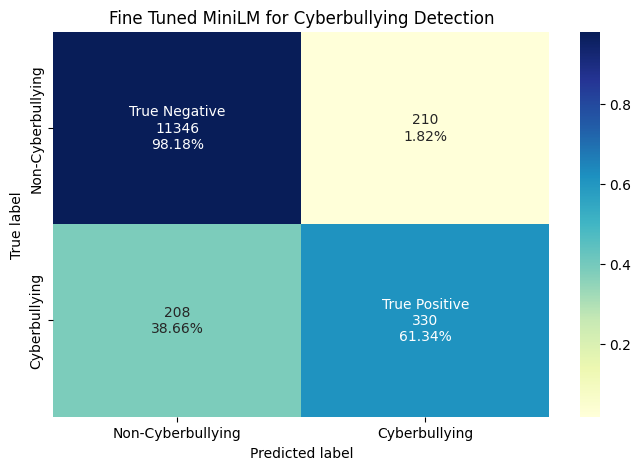

In [10]:
compute_metrics_holdout(model_name='MiniLM',
                        model_path='content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-6803', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 2

loading configuration file content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-13606/config.json
Model config BertConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-13606",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-13606/pyt

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11556
           1       0.61      0.63      0.62       538

    accuracy                           0.97     12094
   macro avg       0.80      0.81      0.80     12094
weighted avg       0.97      0.97      0.97     12094


Label 1: Cyberbullying
Precision:  0.6075268817204301
Recall:  0.6301115241635687
F-measure:  0.6186131386861313

Label 0: Non-Cyberbullying
Precision:  0.982749653259362
Recall:  0.981048805815161
F-measure:  0.9818984929845834

Macro Metrics
Precision:  0.7951382674898961
Recall:  0.8055801649893648
F-measure:  0.8002558158353574



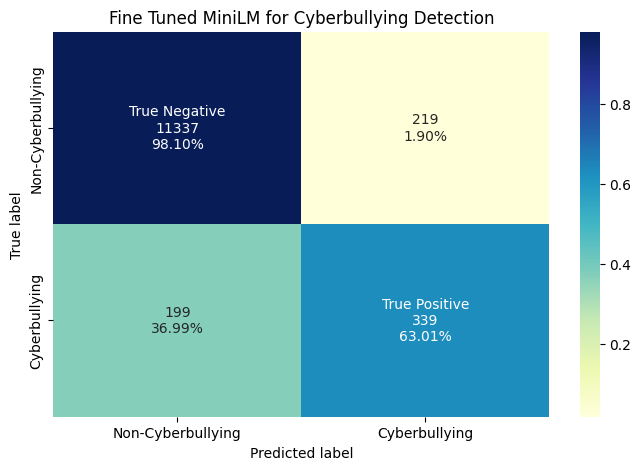

In [11]:
compute_metrics_holdout(model_name='MiniLM',
                        model_path='content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-13606', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 3

loading configuration file content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-20409/config.json
Model config BertConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-20409",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-20409/pyt

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11556
           1       0.65      0.57      0.61       538

    accuracy                           0.97     12094
   macro avg       0.81      0.78      0.80     12094
weighted avg       0.97      0.97      0.97     12094


Label 1: Cyberbullying
Precision:  0.6470588235294118
Recall:  0.5724907063197026
F-measure:  0.6074950690335306

Label 0: Non-Cyberbullying
Precision:  0.9802031330693751
Recall:  0.9854620976116303
F-measure:  0.9828255803918184

Macro Metrics
Precision:  0.8136309782993935
Recall:  0.7789764019656664
F-measure:  0.7951603247126745



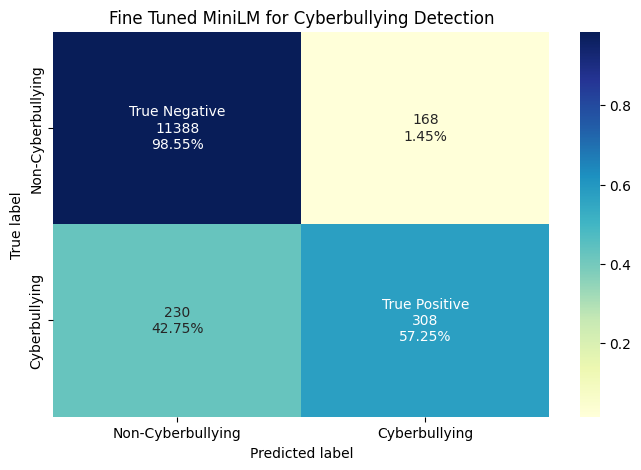

In [12]:
compute_metrics_holdout(model_name='MiniLM',
                        model_path='content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-20409', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 4

loading configuration file content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-27212/config.json
Model config BertConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-27212",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-27212/pyt

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11556
           1       0.63      0.56      0.59       538

    accuracy                           0.97     12094
   macro avg       0.80      0.77      0.79     12094
weighted avg       0.96      0.97      0.96     12094


Label 1: Cyberbullying
Precision:  0.6273291925465838
Recall:  0.5631970260223048
F-measure:  0.5935357492654261

Label 0: Non-Cyberbullying
Precision:  0.9797605718715011
Recall:  0.9844236760124611
F-measure:  0.9820865886821772

Macro Metrics
Precision:  0.8035448822090425
Recall:  0.7738103510173829
F-measure:  0.7878111689738017



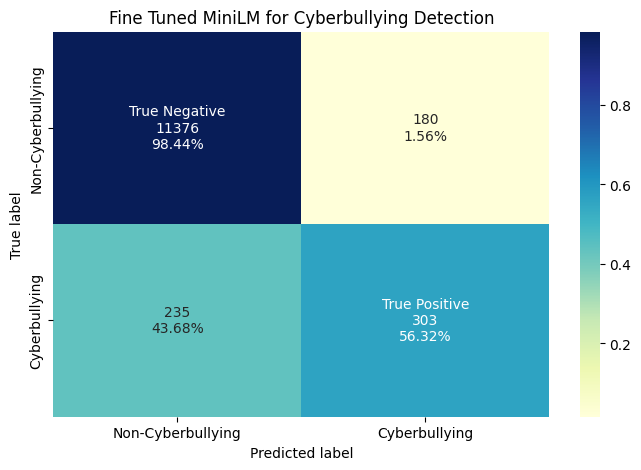

In [13]:
compute_metrics_holdout(model_name='MiniLM',
                        model_path='content/drive/MyDrive_binary/output_MiniLM/holdout/checkpoint-27212', 
                        average_method='binary',
                        X_test=X_test)